In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

from brevitas.export import export_onnx_qcdq

import torchmetrics

import cv2

import config
import dataset_dfire
import datasets
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tBrevitas with All Layers defined in the Model, but Dropout and Flatten.\n' +
            '\tBit width of Big Layers separated.\n' +
            '\tQuantIdentity with Uint8Act added and constant scale factor.\n' +
            '\tWeights with Per Channel Quant.\n' +
            '\tIntBias, Internal Scale with FixedPoint.\n' +
            '\tFASDD Val added.\n' +
            f'\tFixed Point: {config.FIXED_POINT}.\n' +
            f'\tFuse BN: {config.FUSE_BN}.\n' +
            f'\tWeights bit width = {config.WEIGHTS_BIT_WIDTH}.\n' +
            f'\tBig Layers Weights bit width = {config.BIG_LAYERS_WEIGHTS_BIT_WIDTH}.\n' +
            f'\tActivations bit width = {config.ACTIVATIONS_BIT_WIDTH}.\n' +
            f'\tBias bit width = {config.BIAS_BIT_WIDTH}.\n' +
            f'\t{config.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset_dfire.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

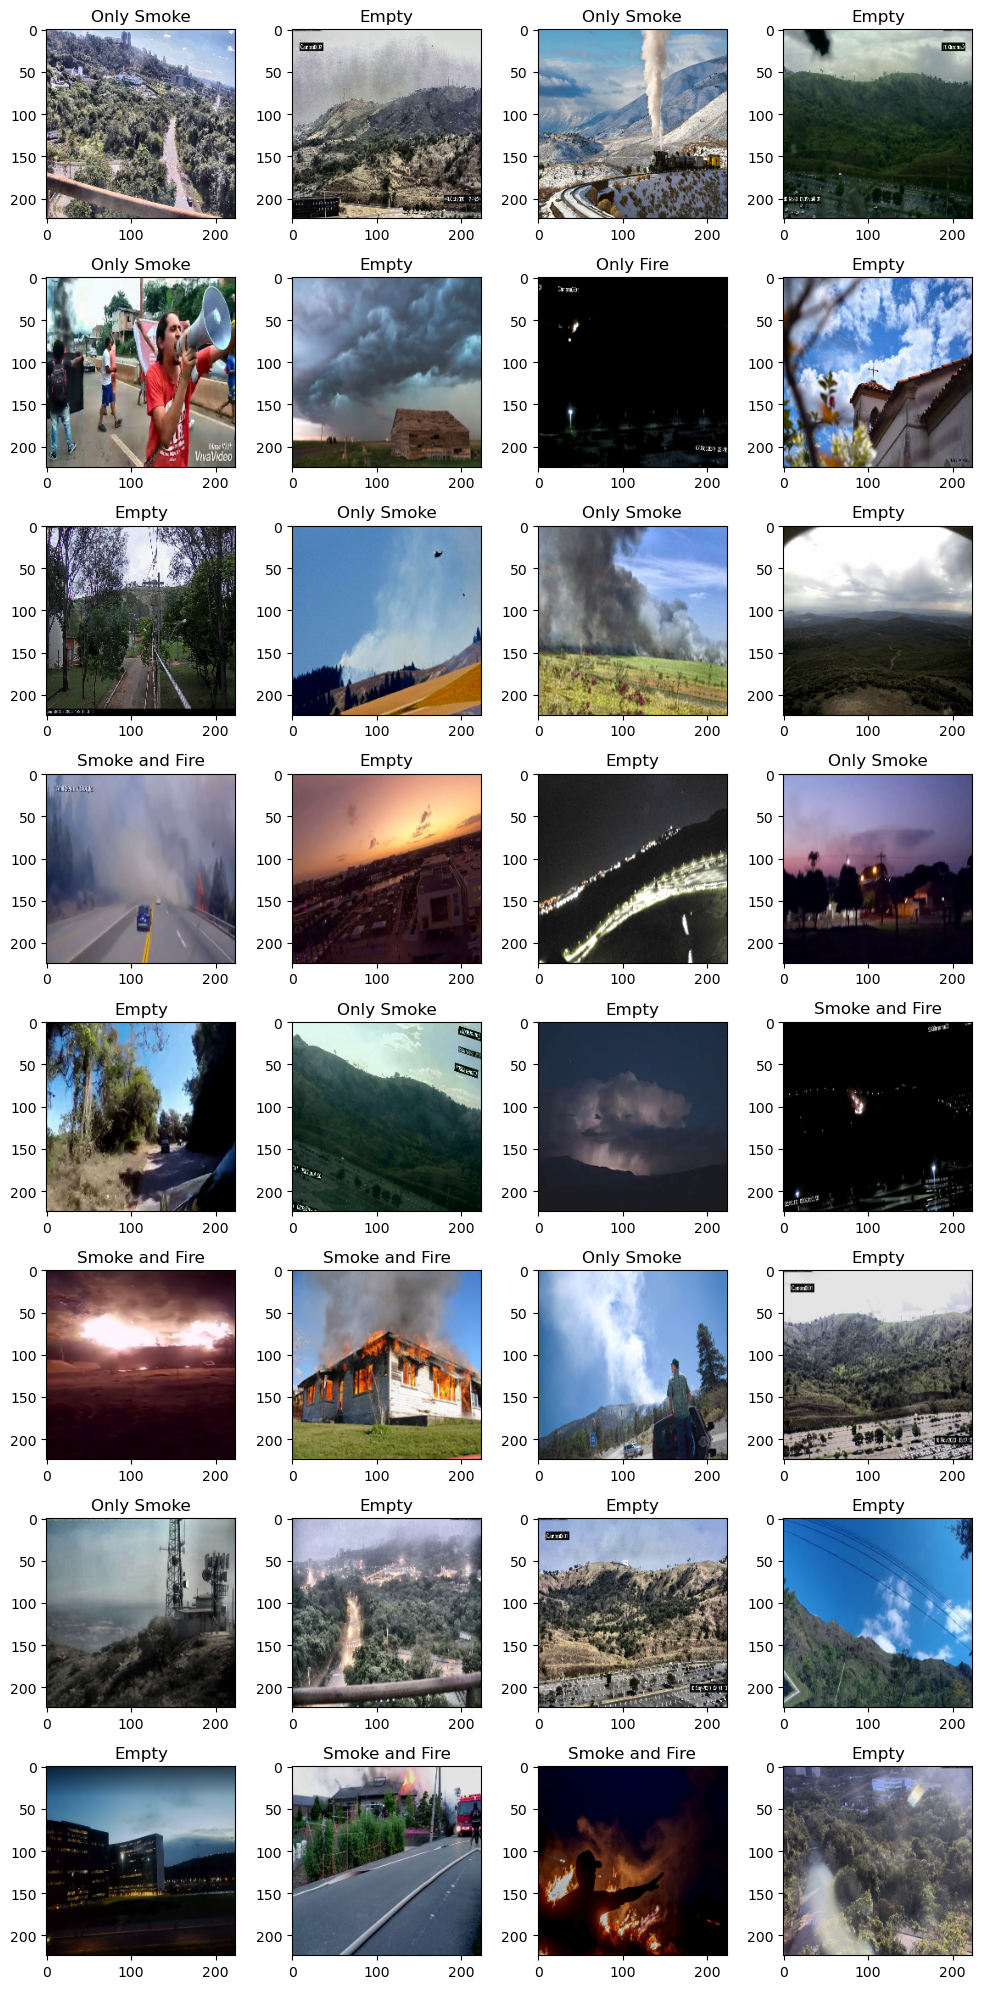

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_loader = datasets.get_train_loader()
val_loader = datasets.get_val_loader()


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763

Train DFire dataset len: 17221

TRAIN FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 5994
DFire only smoke images: 2541
DFire only fire images: 105
DFire smoke and fire images: 3911

Train FASDD UAV dataset len: 12551

VAL FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 3995
DFire only smoke images: 1693
DFire only fire images: 70
DFire smoke and fire images: 2607

Val FASDD UAV dataset len: 8365

TRAIN FASDD CV dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 19600
DFire only smoke images: 11708
DFire only fire images: 6276
DFire smoke and fire images: 10076

Train FASDD CV dataset len: 47660

Val FASDD CV dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 13066
DFire only smoke images: 7804
DFire only fire images: 4183
DFire smoke and fire images: 6717

Val FASDD CV dataset len: 31770

Concatenate Train DFire and Train FASDD UAV datasets
Train dataset len: 29772
Concatenate with Val FASDD UAV dataset
Train dataset len: 38137
Concatenate with Train FASDD CV dataset
Train dataset len: 85797
Concatenate with Val FASDD CV dataset
Train dataset len: 117567

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306

TEST FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 1997
DFire only smoke images: 846
DFire only fire images: 35
DFire smoke and fire images: 1303

Test FASDD UAV dataset len: 4181

TEST FASDD CV dataset
DFire Removed wrong images: 0
DFire empty images: 6533
DFire only smoke images: 3902
DFire only fire images: 2091
DFire smoke and 

# Models Setup

In [8]:
if config.MODEL == "BED":
    
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.FUSED_BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)  
    
    if config.FIXED_POINT == True and config.FUSE_BN == False:
        print("Using Fixed Point Quantizers with BN")
        logger.info("Using Fixed Point Quantizers with BN")
        quant_model = models.QUANT_FixedPoint_BED_CLASSIFIER(
                weight_bw = config.WEIGHTS_BIT_WIDTH,
                act_bw = config.ACTIVATIONS_BIT_WIDTH,
                bias_bw = config.BIAS_BIT_WIDTH,
                num_classes=config.N_CLASSES).to(config.DEVICE)
    elif config.FIXED_POINT == True and config.FUSE_BN == True:
        print("Using Fixed Point Quantizers without BN")
        logger.info("Using Fixed Point Quantizers without BN")
        quant_model = models.QUANT_FixedPoint_NoBN_BED_CLASSIFIER(
                weight_bw = config.WEIGHTS_BIT_WIDTH,
                big_layers_weight_bw = config.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
                act_bw = config.ACTIVATIONS_BIT_WIDTH,
                bias_bw = config.BIAS_BIT_WIDTH,
                num_classes=config.N_CLASSES).to(config.DEVICE)
    else:
        quant_model = models.QUANT_BED_CLASSIFIER(
            weight_bw = config.WEIGHTS_BIT_WIDTH,
            act_bw = config.ACTIVATIONS_BIT_WIDTH,
            bias_bw = config.BIAS_BIT_WIDTH,
            num_classes=config.N_CLASSES).to(config.DEVICE)  
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(quant_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in quant_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(quant_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Using Fixed Point Quantizers without BN

Trainable parameters = 93297
Total parameters = 93297



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = quant_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{quant_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{quant_model}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[ 0.1073, -0.0564],
        [ 0.1008, -0.0539],
        [ 0.0955, -0.0534],
        [ 0.1026, -0.0540]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
QUANT_FixedPoint_NoBN_BED_CLASSIFIER(
  (model): Sequential(
    (input0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
                (cl

# Load Pretrained or Initialize Weights

In [10]:
fp32_optimizer = optim.Adam(
    fp32_model.parameters(), 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY)

fp32_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    fp32_optimizer, 
    mode='min',
    factor=config.FACTOR, 
    patience=config.PATIENCE, 
    threshold=config.THRES, 
    threshold_mode='abs',
    min_lr=config.MIN_LR)

if config.LOAD_MODEL == False:
    if config.MODEL == "BED":
        fp32_model.__initialize_weights__()
        print("Initializing Weights")
        logger.info("Initializing Weights")
else:
    epochs_trained = utils.load_checkpoint(config.LOAD_MODEL_FILE, fp32_model, fp32_optimizer, fp32_scheduler, config.DEVICE)
    logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 87 epochs


# Torchinfo: model summary

### Quant Model

In [11]:
print(summary(quant_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info("Quant Model Summary")
logger.info(summary(quant_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                                                      Output Shape              Param #
QUANT_FixedPoint_NoBN_BED_CLASSIFIER                                        [1, 2]                    --
├─Sequential: 1-1                                                           [1, 2]                    --
│    └─QuantIdentity: 2-1                                                   [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-1                                  [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-2                                  [1, 3, 224, 224]          --
│    └─QuantReLU: 2-55                                                      --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-99                                 --                        (recursive)
│    └─QuantIdentity: 2-3                                                   --                        --
│    │    └─ActQuantProxyFromInj

### FP32 Model

In [12]:
fp32_model.eval() # Do it before using the model for inference
print(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
FUSED_BED_CLASSIFIER                     [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─Dropout2d: 2-3                    [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 16, 112, 112]         4,624
│    └─ReLU: 2-6                         [1, 16, 112, 112]         --
│    └─Dropout2d: 2-7                    [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-8                    [1, 16, 56, 56]           --
│    └─Conv2d: 2-9                       [1, 16, 56, 56]           272
│    └─ReLU: 2-10                        [1, 16, 56, 56]           --
│    └─Conv2d: 2-11                      [1, 32, 56, 56]           4,640
│    └─

# Load Pretrained Weights from FP32 Model to Quant Model

In [13]:
# # Try to load fp32 weights to quant_model
from brevitas import config as brevitas_config

brevitas_config.IGNORE_MISSING_KEYS = True

### Load all Pretrained Weights

In [14]:
for fp32_name, fp32_mod in fp32_model.named_modules():
    for quant_name, quant_mod in  quant_model.named_modules():
        if fp32_name == quant_name:
            print(f'fp32 model name: {fp32_name} - quant model name: {quant_name}')
            if isinstance(fp32_mod, nn.Conv2d):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Conv2d layer fp32 {fp32_name} into quant {quant_name}')
            elif isinstance(fp32_mod, nn.Linear):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Linear layer fp32 {fp32_name} into quant {quant_name}')
            else:
                print(f'\t______ Ignore weights or params of layer fp32 {fp32_name} and quant {quant_name}')

fp32 model name:  - quant model name: 
	______ Ignore weights or params of layer fp32  and quant 
fp32 model name: model - quant model name: model
	______ Ignore weights or params of layer fp32 model and quant model
fp32 model name: model.conv1 - quant model name: model.conv1
	****** Loading weights of Conv2d layer fp32 model.conv1 into quant model.conv1
fp32 model name: model.relu1 - quant model name: model.relu1
	______ Ignore weights or params of layer fp32 model.relu1 and quant model.relu1
fp32 model name: model.dropout1 - quant model name: model.dropout1
	______ Ignore weights or params of layer fp32 model.dropout1 and quant model.dropout1
fp32 model name: model.maxpool2 - quant model name: model.maxpool2
	______ Ignore weights or params of layer fp32 model.maxpool2 and quant model.maxpool2
fp32 model name: model.conv2 - quant model name: model.conv2
	****** Loading weights of Conv2d layer fp32 model.conv2 into quant model.conv2
fp32 model name: model.relu2 - quant model name: mod

# Loss Function

In [15]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [16]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [17]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [18]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    
    print("Starting script\n")
    logger.info("Starting script\n")
    
    qnn_model = train_loop(model=quant_model)

Starting script


***Start Training: 13:28:13


=== EPOCH 0/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [08:13<00:00,  3.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.516      |16.159      |10.357      



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.118      |14.650      |7.467       
SMOKE -> Precision: 0.885 - Recall: 0.900 - Accuracy: 0.898 - F1: 0.893
FIRE -> Precision: 0.921 - Recall: 0.945 - Accuracy: 0.956 - F1: 0.933

Saving model with new best validation loss: 22.118
Saving model with best Mean F1: 0.9128

=== EPOCH 1/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:02<00:00,  6.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.667      |13.897      |8.770       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.369      |13.394      |6.975       
SMOKE -> Precision: 0.935 - Recall: 0.842 - Accuracy: 0.898 - F1: 0.886
FIRE -> Precision: 0.925 - Recall: 0.955 - Accuracy: 0.960 - F1: 0.940

Saving model with new best validation loss: 20.369
Saving model with best Mean F1: 0.9129

=== EPOCH 2/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.140      |13.571      |8.569       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.134      |14.146      |9.988       
SMOKE -> Precision: 0.919 - Recall: 0.858 - Accuracy: 0.898 - F1: 0.888
FIRE -> Precision: 0.871 - Recall: 0.971 - Accuracy: 0.944 - F1: 0.918

=== EPOCH 3/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.804      |13.448      |8.356       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.321      |14.595      |9.726       
SMOKE -> Precision: 0.878 - Recall: 0.904 - Accuracy: 0.896 - F1: 0.891
FIRE -> Precision: 0.870 - Recall: 0.973 - Accuracy: 0.944 - F1: 0.918

=== EPOCH 4/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.678      |13.326      |8.351       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.236      |15.126      |8.111       
SMOKE -> Precision: 0.914 - Recall: 0.854 - Accuracy: 0.893 - F1: 0.883
FIRE -> Precision: 0.897 - Recall: 0.965 - Accuracy: 0.953 - F1: 0.930

=== EPOCH 5/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.136      |13.036      |8.100       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.323      |14.085      |8.238       
SMOKE -> Precision: 0.894 - Recall: 0.908 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.890 - Recall: 0.967 - Accuracy: 0.951 - F1: 0.927

Saving model with new best smoke precision: 0.894
Saving model with best Mean F1: 0.9140

=== EPOCH 6/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.029      |12.920      |8.110       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.441      |14.891      |7.551       
SMOKE -> Precision: 0.880 - Recall: 0.908 - Accuracy: 0.898 - F1: 0.894
FIRE -> Precision: 0.925 - Recall: 0.932 - Accuracy: 0.953 - F1: 0.928

=== EPOCH 7/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.071      |12.947      |8.123       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.398      |13.162      |8.236       
SMOKE -> Precision: 0.900 - Recall: 0.915 - Accuracy: 0.912 - F1: 0.907
FIRE -> Precision: 0.892 - Recall: 0.974 - Accuracy: 0.953 - F1: 0.931

Saving model with new best smoke precision: 0.900
Saving model with best Mean F1: 0.9191

=== EPOCH 8/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.904      |12.855      |8.048       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.352      |13.080      |6.272       
SMOKE -> Precision: 0.954 - Recall: 0.848 - Accuracy: 0.909 - F1: 0.898
FIRE -> Precision: 0.943 - Recall: 0.945 - Accuracy: 0.964 - F1: 0.944

Saving model with new best validation loss: 19.352
Saving model with best Mean F1: 0.9210

=== EPOCH 9/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.628      |12.660      |7.968       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.471      |12.873      |6.599       
SMOKE -> Precision: 0.932 - Recall: 0.865 - Accuracy: 0.906 - F1: 0.897
FIRE -> Precision: 0.922 - Recall: 0.962 - Accuracy: 0.962 - F1: 0.942

=== EPOCH 10/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.783      |12.796      |7.987       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.743      |14.491      |7.252       
SMOKE -> Precision: 0.913 - Recall: 0.865 - Accuracy: 0.897 - F1: 0.888
FIRE -> Precision: 0.920 - Recall: 0.956 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 11/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.566      |12.642      |7.924       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.623      |12.245      |6.378       
SMOKE -> Precision: 0.953 - Recall: 0.858 - Accuracy: 0.913 - F1: 0.903
FIRE -> Precision: 0.932 - Recall: 0.954 - Accuracy: 0.963 - F1: 0.943

Saving model with new best validation loss: 18.623

Saving model with new best smoke precision: 0.953
Saving model with best Mean F1: 0.9230

=== EPOCH 12/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.773      |12.681      |8.091       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.607      |12.121      |7.486       
SMOKE -> Precision: 0.927 - Recall: 0.890 - Accuracy: 0.915 - F1: 0.908
FIRE -> Precision: 0.901 - Recall: 0.971 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 13/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.609      |12.685      |7.924       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.761      |14.228      |9.533       
SMOKE -> Precision: 0.918 - Recall: 0.870 - Accuracy: 0.902 - F1: 0.893
FIRE -> Precision: 0.864 - Recall: 0.980 - Accuracy: 0.944 - F1: 0.918

=== EPOCH 14/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.541      |12.663      |7.879       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.921      |15.613      |7.308       
SMOKE -> Precision: 0.851 - Recall: 0.942 - Accuracy: 0.895 - F1: 0.894
FIRE -> Precision: 0.920 - Recall: 0.946 - Accuracy: 0.956 - F1: 0.933

=== EPOCH 15/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.232      |12.473      |7.759       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.378      |11.670      |6.708       
SMOKE -> Precision: 0.919 - Recall: 0.907 - Accuracy: 0.918 - F1: 0.913
FIRE -> Precision: 0.931 - Recall: 0.947 - Accuracy: 0.960 - F1: 0.939

Saving model with new best validation loss: 18.378

Saving model with precision > 0.9 and recall > 0.9
Saving model with best Mean F1: 0.9258

=== EPOCH 16/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.190      |12.425      |7.765       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.770      |11.911      |6.859       
SMOKE -> Precision: 0.938 - Recall: 0.886 - Accuracy: 0.919 - F1: 0.912
FIRE -> Precision: 0.919 - Recall: 0.961 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 17/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.086      |12.419      |7.666       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.769      |12.514      |9.255       
SMOKE -> Precision: 0.919 - Recall: 0.896 - Accuracy: 0.914 - F1: 0.908
FIRE -> Precision: 0.872 - Recall: 0.975 - Accuracy: 0.946 - F1: 0.921

=== EPOCH 18/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.324      |12.407      |7.917       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.161      |11.743      |6.419       
SMOKE -> Precision: 0.924 - Recall: 0.902 - Accuracy: 0.919 - F1: 0.913
FIRE -> Precision: 0.923 - Recall: 0.963 - Accuracy: 0.962 - F1: 0.943

Saving model with new best validation loss: 18.161

Saving model with precision > 0.9 and recall > 0.9
Saving model with best Mean F1: 0.9279

=== EPOCH 19/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.330      |12.499      |7.831       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.993      |11.604      |6.389       
SMOKE -> Precision: 0.948 - Recall: 0.879 - Accuracy: 0.920 - F1: 0.912
FIRE -> Precision: 0.928 - Recall: 0.959 - Accuracy: 0.963 - F1: 0.943

Saving model with new best validation loss: 17.993

=== EPOCH 20/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.319      |12.472      |7.847       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.659      |13.540      |8.119       
SMOKE -> Precision: 0.909 - Recall: 0.891 - Accuracy: 0.906 - F1: 0.900
FIRE -> Precision: 0.888 - Recall: 0.973 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 21/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.225      |12.384      |7.841       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.868      |12.892      |6.976       
SMOKE -> Precision: 0.921 - Recall: 0.898 - Accuracy: 0.916 - F1: 0.910
FIRE -> Precision: 0.919 - Recall: 0.956 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 22/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.173      |12.425      |7.748       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.233      |14.208      |9.025       
SMOKE -> Precision: 0.944 - Recall: 0.828 - Accuracy: 0.896 - F1: 0.882
FIRE -> Precision: 0.879 - Recall: 0.965 - Accuracy: 0.946 - F1: 0.920

=== EPOCH 23/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.718      |12.123      |7.595       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.978      |11.485      |5.492       
SMOKE -> Precision: 0.950 - Recall: 0.878 - Accuracy: 0.921 - F1: 0.913
FIRE -> Precision: 0.953 - Recall: 0.951 - Accuracy: 0.969 - F1: 0.952

Saving model with new best validation loss: 16.978
Saving model with best Mean F1: 0.9323

=== EPOCH 24/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.964      |12.289      |7.676       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.797      |11.645      |7.151       
SMOKE -> Precision: 0.936 - Recall: 0.894 - Accuracy: 0.921 - F1: 0.914
FIRE -> Precision: 0.907 - Recall: 0.969 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 25/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.893      |12.220      |7.673       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.981      |13.089      |6.892       
SMOKE -> Precision: 0.885 - Recall: 0.940 - Accuracy: 0.914 - F1: 0.912
FIRE -> Precision: 0.921 - Recall: 0.960 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 26/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.963      |12.258      |7.705       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.970      |11.521      |6.450       
SMOKE -> Precision: 0.924 - Recall: 0.905 - Accuracy: 0.920 - F1: 0.914
FIRE -> Precision: 0.930 - Recall: 0.954 - Accuracy: 0.962 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 27/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.459      |11.944      |7.515       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.307      |11.160      |6.148       
SMOKE -> Precision: 0.953 - Recall: 0.864 - Accuracy: 0.916 - F1: 0.906
FIRE -> Precision: 0.940 - Recall: 0.950 - Accuracy: 0.964 - F1: 0.945

=== EPOCH 28/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.655      |12.032      |7.623       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.487      |11.418      |7.069       
SMOKE -> Precision: 0.941 - Recall: 0.896 - Accuracy: 0.925 - F1: 0.918
FIRE -> Precision: 0.910 - Recall: 0.967 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 29/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.758      |12.103      |7.655       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.558      |11.826      |6.732       
SMOKE -> Precision: 0.928 - Recall: 0.897 - Accuracy: 0.919 - F1: 0.912
FIRE -> Precision: 0.919 - Recall: 0.965 - Accuracy: 0.961 - F1: 0.941

=== EPOCH 30/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.579      |12.055      |7.525       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.878      |12.654      |6.224       
SMOKE -> Precision: 0.901 - Recall: 0.925 - Accuracy: 0.917 - F1: 0.913
FIRE -> Precision: 0.930 - Recall: 0.964 - Accuracy: 0.965 - F1: 0.947

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 31/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.714      |12.104      |7.610       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.316      |11.784      |7.532       
SMOKE -> Precision: 0.946 - Recall: 0.879 - Accuracy: 0.920 - F1: 0.912
FIRE -> Precision: 0.900 - Recall: 0.969 - Accuracy: 0.955 - F1: 0.933

=== EPOCH 32/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.640      |12.077      |7.562       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.896      |14.335      |7.562       
SMOKE -> Precision: 0.882 - Recall: 0.919 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.902 - Recall: 0.975 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 33/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.288      |11.895      |7.393       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.964      |12.593      |7.371       
SMOKE -> Precision: 0.908 - Recall: 0.912 - Accuracy: 0.915 - F1: 0.910
FIRE -> Precision: 0.898 - Recall: 0.975 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 34/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.298      |11.846      |7.451       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.639      |12.778      |7.862       
SMOKE -> Precision: 0.901 - Recall: 0.922 - Accuracy: 0.916 - F1: 0.912
FIRE -> Precision: 0.888 - Recall: 0.976 - Accuracy: 0.953 - F1: 0.930

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 35/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.228      |11.904      |7.324       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.396      |13.057      |7.339       
SMOKE -> Precision: 0.898 - Recall: 0.912 - Accuracy: 0.910 - F1: 0.905
FIRE -> Precision: 0.904 - Recall: 0.964 - Accuracy: 0.955 - F1: 0.933

=== EPOCH 36/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.045      |11.691      |7.354       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.483      |11.360      |6.124       
SMOKE -> Precision: 0.934 - Recall: 0.898 - Accuracy: 0.922 - F1: 0.915
FIRE -> Precision: 0.932 - Recall: 0.964 - Accuracy: 0.965 - F1: 0.948

=== EPOCH 37/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.137      |11.746      |7.391       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.875      |12.956      |6.919       
SMOKE -> Precision: 0.940 - Recall: 0.862 - Accuracy: 0.909 - F1: 0.899
FIRE -> Precision: 0.915 - Recall: 0.968 - Accuracy: 0.960 - F1: 0.941

=== EPOCH 38/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.161      |11.760      |7.402       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.327      |11.425      |6.903       
SMOKE -> Precision: 0.926 - Recall: 0.910 - Accuracy: 0.923 - F1: 0.918
FIRE -> Precision: 0.917 - Recall: 0.969 - Accuracy: 0.962 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 39/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.856      |11.574      |7.281       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.146      |13.137      |11.010      
SMOKE -> Precision: 0.901 - Recall: 0.910 - Accuracy: 0.911 - F1: 0.906
FIRE -> Precision: 0.830 - Recall: 0.990 - Accuracy: 0.931 - F1: 0.903

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 40/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.911      |11.613      |7.298       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.864      |13.241      |9.623       
SMOKE -> Precision: 0.884 - Recall: 0.931 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.862 - Recall: 0.977 - Accuracy: 0.942 - F1: 0.916

=== EPOCH 41/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.014      |11.655      |7.360       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.354      |11.555      |6.799       
SMOKE -> Precision: 0.938 - Recall: 0.894 - Accuracy: 0.922 - F1: 0.915
FIRE -> Precision: 0.918 - Recall: 0.967 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 42/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.924      |11.590      |7.335       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.956      |11.208      |5.747       
SMOKE -> Precision: 0.925 - Recall: 0.914 - Accuracy: 0.925 - F1: 0.920
FIRE -> Precision: 0.941 - Recall: 0.959 - Accuracy: 0.967 - F1: 0.950

Saving model with new best validation loss: 16.956

Saving model with precision > 0.9 and recall > 0.9
Saving model with best Mean F1: 0.9347

=== EPOCH 43/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.912      |11.618      |7.294       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.682      |11.934      |8.747       
SMOKE -> Precision: 0.943 - Recall: 0.876 - Accuracy: 0.916 - F1: 0.908
FIRE -> Precision: 0.881 - Recall: 0.976 - Accuracy: 0.949 - F1: 0.926

=== EPOCH 44/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.848      |11.530      |7.318       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.155      |12.813      |7.342       
SMOKE -> Precision: 0.899 - Recall: 0.920 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.900 - Recall: 0.976 - Accuracy: 0.957 - F1: 0.937

=== EPOCH 45/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.892      |11.629      |7.263       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.700      |12.356      |8.344       
SMOKE -> Precision: 0.941 - Recall: 0.876 - Accuracy: 0.916 - F1: 0.907
FIRE -> Precision: 0.888 - Recall: 0.972 - Accuracy: 0.951 - F1: 0.928

=== EPOCH 46/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.645      |11.464      |7.180       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.036      |12.329      |8.707       
SMOKE -> Precision: 0.929 - Recall: 0.889 - Accuracy: 0.916 - F1: 0.909
FIRE -> Precision: 0.877 - Recall: 0.975 - Accuracy: 0.947 - F1: 0.923

=== EPOCH 47/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.800      |11.600      |7.200       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.316      |11.768      |6.548       
SMOKE -> Precision: 0.912 - Recall: 0.929 - Accuracy: 0.924 - F1: 0.920
FIRE -> Precision: 0.928 - Recall: 0.957 - Accuracy: 0.962 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 48/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.913      |11.627      |7.286       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.549      |10.933      |5.616       
SMOKE -> Precision: 0.950 - Recall: 0.882 - Accuracy: 0.922 - F1: 0.915
FIRE -> Precision: 0.944 - Recall: 0.959 - Accuracy: 0.968 - F1: 0.952

Saving model with new best validation loss: 16.549

=== EPOCH 49/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.864      |11.696      |7.168       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.497      |13.612      |7.886       
SMOKE -> Precision: 0.885 - Recall: 0.928 - Accuracy: 0.909 - F1: 0.906
FIRE -> Precision: 0.889 - Recall: 0.978 - Accuracy: 0.953 - F1: 0.932

=== EPOCH 50/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.877      |11.641      |7.236       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.710      |11.778      |7.932       
SMOKE -> Precision: 0.937 - Recall: 0.890 - Accuracy: 0.920 - F1: 0.913
FIRE -> Precision: 0.903 - Recall: 0.965 - Accuracy: 0.955 - F1: 0.933

=== EPOCH 51/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.825      |11.531      |7.294       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.580      |11.248      |6.332       
SMOKE -> Precision: 0.952 - Recall: 0.878 - Accuracy: 0.922 - F1: 0.914
FIRE -> Precision: 0.925 - Recall: 0.967 - Accuracy: 0.964 - F1: 0.945

=== EPOCH 52/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.754      |11.578      |7.175       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.112      |13.479      |7.633       
SMOKE -> Precision: 0.889 - Recall: 0.926 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.894 - Recall: 0.978 - Accuracy: 0.955 - F1: 0.934

=== EPOCH 53/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.767      |11.565      |7.202       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.519      |12.360      |8.160       
SMOKE -> Precision: 0.915 - Recall: 0.909 - Accuracy: 0.917 - F1: 0.912
FIRE -> Precision: 0.889 - Recall: 0.976 - Accuracy: 0.953 - F1: 0.930

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 54/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.766      |11.498      |7.269       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.905      |11.733      |8.172       
SMOKE -> Precision: 0.919 - Recall: 0.913 - Accuracy: 0.921 - F1: 0.916
FIRE -> Precision: 0.885 - Recall: 0.983 - Accuracy: 0.953 - F1: 0.931

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 55/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.526      |11.381      |7.145       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.517      |12.408      |6.109       
SMOKE -> Precision: 0.963 - Recall: 0.844 - Accuracy: 0.911 - F1: 0.900
FIRE -> Precision: 0.933 - Recall: 0.962 - Accuracy: 0.966 - F1: 0.948

=== EPOCH 56/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.576      |11.413      |7.163       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.712      |12.112      |6.599       
SMOKE -> Precision: 0.908 - Recall: 0.921 - Accuracy: 0.919 - F1: 0.914
FIRE -> Precision: 0.920 - Recall: 0.970 - Accuracy: 0.963 - F1: 0.944

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 57/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.682      |11.502      |7.180       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.959      |11.696      |6.263       
SMOKE -> Precision: 0.915 - Recall: 0.917 - Accuracy: 0.921 - F1: 0.916
FIRE -> Precision: 0.934 - Recall: 0.958 - Accuracy: 0.964 - F1: 0.946

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 58/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.535      |11.396      |7.139       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.681      |12.164      |9.517       
SMOKE -> Precision: 0.945 - Recall: 0.875 - Accuracy: 0.917 - F1: 0.908
FIRE -> Precision: 0.870 - Recall: 0.976 - Accuracy: 0.945 - F1: 0.920

=== EPOCH 59/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.596      |11.400      |7.195       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.300      |11.568      |7.733       
SMOKE -> Precision: 0.917 - Recall: 0.914 - Accuracy: 0.921 - F1: 0.916
FIRE -> Precision: 0.897 - Recall: 0.977 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 60/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.597      |11.450      |7.147       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.012      |12.679      |6.333       
SMOKE -> Precision: 0.900 - Recall: 0.928 - Accuracy: 0.917 - F1: 0.913
FIRE -> Precision: 0.919 - Recall: 0.975 - Accuracy: 0.964 - F1: 0.946

=== EPOCH 61/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.510      |11.378      |7.132       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.589      |12.773      |6.815       
SMOKE -> Precision: 0.895 - Recall: 0.930 - Accuracy: 0.916 - F1: 0.912
FIRE -> Precision: 0.916 - Recall: 0.966 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 62/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.559      |11.412      |7.147       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.423      |11.443      |6.980       
SMOKE -> Precision: 0.944 - Recall: 0.886 - Accuracy: 0.922 - F1: 0.914
FIRE -> Precision: 0.908 - Recall: 0.974 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 63/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.655      |11.509      |7.146       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.516      |11.422      |7.094       
SMOKE -> Precision: 0.926 - Recall: 0.909 - Accuracy: 0.923 - F1: 0.917
FIRE -> Precision: 0.902 - Recall: 0.979 - Accuracy: 0.959 - F1: 0.939

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 64/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.487      |11.375      |7.112       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.004      |11.084      |6.919       
SMOKE -> Precision: 0.939 - Recall: 0.903 - Accuracy: 0.927 - F1: 0.921
FIRE -> Precision: 0.916 - Recall: 0.969 - Accuracy: 0.961 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 65/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.371      |11.225      |7.147       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.809      |11.737      |6.071       
SMOKE -> Precision: 0.912 - Recall: 0.923 - Accuracy: 0.922 - F1: 0.917
FIRE -> Precision: 0.928 - Recall: 0.969 - Accuracy: 0.965 - F1: 0.948

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 66/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.421      |11.275      |7.146       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.100      |11.969      |6.131       
SMOKE -> Precision: 0.912 - Recall: 0.917 - Accuracy: 0.919 - F1: 0.914
FIRE -> Precision: 0.930 - Recall: 0.963 - Accuracy: 0.965 - F1: 0.946

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 67/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.341      |11.287      |7.054       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.212      |11.273      |5.939       
SMOKE -> Precision: 0.955 - Recall: 0.866 - Accuracy: 0.917 - F1: 0.908
FIRE -> Precision: 0.941 - Recall: 0.959 - Accuracy: 0.967 - F1: 0.950

Saving model with new best smoke precision: 0.955

=== EPOCH 68/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.410      |11.306      |7.104       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.891      |11.153      |6.739       
SMOKE -> Precision: 0.938 - Recall: 0.899 - Accuracy: 0.924 - F1: 0.918
FIRE -> Precision: 0.910 - Recall: 0.976 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 69/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.547      |11.427      |7.120       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.397      |10.664      |5.733       
SMOKE -> Precision: 0.955 - Recall: 0.882 - Accuracy: 0.925 - F1: 0.917
FIRE -> Precision: 0.937 - Recall: 0.965 - Accuracy: 0.968 - F1: 0.951

Saving model with new best validation loss: 16.397

=== EPOCH 70/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.443      |11.376      |7.067       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.245      |11.409      |6.837       
SMOKE -> Precision: 0.947 - Recall: 0.888 - Accuracy: 0.924 - F1: 0.916
FIRE -> Precision: 0.914 - Recall: 0.976 - Accuracy: 0.962 - F1: 0.944

=== EPOCH 71/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.499      |11.361      |7.139       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.894      |11.927      |6.967       
SMOKE -> Precision: 0.921 - Recall: 0.910 - Accuracy: 0.921 - F1: 0.916
FIRE -> Precision: 0.913 - Recall: 0.968 - Accuracy: 0.960 - F1: 0.940

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 72/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.630      |11.424      |7.206       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.222      |12.565      |6.657       
SMOKE -> Precision: 0.908 - Recall: 0.921 - Accuracy: 0.919 - F1: 0.914
FIRE -> Precision: 0.914 - Recall: 0.974 - Accuracy: 0.962 - F1: 0.943

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 73/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.399      |11.313      |7.086       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.968      |12.385      |6.584       
SMOKE -> Precision: 0.897 - Recall: 0.931 - Accuracy: 0.917 - F1: 0.914
FIRE -> Precision: 0.915 - Recall: 0.971 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 74/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.359      |11.263      |7.096       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.422      |13.836      |8.587       
SMOKE -> Precision: 0.886 - Recall: 0.925 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.882 - Recall: 0.973 - Accuracy: 0.949 - F1: 0.926

=== EPOCH 75/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.402      |11.359      |7.043       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.644      |11.835      |6.810       
SMOKE -> Precision: 0.923 - Recall: 0.907 - Accuracy: 0.921 - F1: 0.915
FIRE -> Precision: 0.909 - Recall: 0.976 - Accuracy: 0.961 - F1: 0.941

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 76/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.278      |11.293      |6.985       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.687      |11.490      |6.198       
SMOKE -> Precision: 0.924 - Recall: 0.914 - Accuracy: 0.924 - F1: 0.919
FIRE -> Precision: 0.926 - Recall: 0.970 - Accuracy: 0.965 - F1: 0.947

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 77/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.286      |11.208      |7.078       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.216      |13.566      |8.650       
SMOKE -> Precision: 0.888 - Recall: 0.921 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.879 - Recall: 0.981 - Accuracy: 0.950 - F1: 0.927

=== EPOCH 78/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.385      |11.350      |7.034       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.771      |12.362      |7.409       
SMOKE -> Precision: 0.905 - Recall: 0.922 - Accuracy: 0.917 - F1: 0.913
FIRE -> Precision: 0.904 - Recall: 0.976 - Accuracy: 0.959 - F1: 0.938

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 79/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.370      |11.267      |7.103       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.799      |10.966      |5.833       
SMOKE -> Precision: 0.950 - Recall: 0.896 - Accuracy: 0.929 - F1: 0.922
FIRE -> Precision: 0.936 - Recall: 0.963 - Accuracy: 0.967 - F1: 0.949
Saving model with best Mean F1: 0.9357

=== EPOCH 80/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.411      |11.331      |7.080       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.890      |11.516      |6.373       
SMOKE -> Precision: 0.942 - Recall: 0.892 - Accuracy: 0.923 - F1: 0.916
FIRE -> Precision: 0.923 - Recall: 0.973 - Accuracy: 0.965 - F1: 0.948

=== EPOCH 81/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.243      |11.212      |7.030       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.634      |12.865      |8.769       
SMOKE -> Precision: 0.896 - Recall: 0.924 - Accuracy: 0.914 - F1: 0.910
FIRE -> Precision: 0.876 - Recall: 0.981 - Accuracy: 0.949 - F1: 0.925

=== EPOCH 82/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.245      |11.239      |7.006       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.040      |11.307      |6.734       
SMOKE -> Precision: 0.926 - Recall: 0.915 - Accuracy: 0.925 - F1: 0.921
FIRE -> Precision: 0.916 - Recall: 0.976 - Accuracy: 0.963 - F1: 0.945

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 83/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.364      |11.267      |7.097       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.888      |13.246      |7.642       
SMOKE -> Precision: 0.899 - Recall: 0.919 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.900 - Recall: 0.975 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 84/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.347      |11.250      |7.097       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.412      |12.727      |8.685       
SMOKE -> Precision: 0.922 - Recall: 0.899 - Accuracy: 0.917 - F1: 0.910
FIRE -> Precision: 0.875 - Recall: 0.981 - Accuracy: 0.949 - F1: 0.925

=== EPOCH 85/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.369      |11.283      |7.085       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.490      |11.380      |7.110       
SMOKE -> Precision: 0.940 - Recall: 0.894 - Accuracy: 0.923 - F1: 0.916
FIRE -> Precision: 0.912 - Recall: 0.972 - Accuracy: 0.960 - F1: 0.941

=== EPOCH 86/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.403      |11.304      |7.099       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.412      |10.641      |6.771       
SMOKE -> Precision: 0.949 - Recall: 0.897 - Accuracy: 0.928 - F1: 0.922
FIRE -> Precision: 0.915 - Recall: 0.971 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 87/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.287      |11.227      |7.060       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.387      |11.579      |5.808       
SMOKE -> Precision: 0.942 - Recall: 0.893 - Accuracy: 0.924 - F1: 0.917
FIRE -> Precision: 0.934 - Recall: 0.967 - Accuracy: 0.967 - F1: 0.950

=== EPOCH 88/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.239      |11.260      |6.979       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.601      |10.880      |5.721       
SMOKE -> Precision: 0.943 - Recall: 0.896 - Accuracy: 0.925 - F1: 0.919
FIRE -> Precision: 0.937 - Recall: 0.966 - Accuracy: 0.968 - F1: 0.951

=== EPOCH 89/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.240      |11.076      |7.165       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.288      |11.592      |6.696       
SMOKE -> Precision: 0.915 - Recall: 0.915 - Accuracy: 0.920 - F1: 0.915
FIRE -> Precision: 0.913 - Recall: 0.972 - Accuracy: 0.961 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 90/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.183      |11.169      |7.014       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.427      |11.389      |8.038       
SMOKE -> Precision: 0.943 - Recall: 0.893 - Accuracy: 0.924 - F1: 0.917
FIRE -> Precision: 0.889 - Recall: 0.979 - Accuracy: 0.953 - F1: 0.932

=== EPOCH 91/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.281      |11.247      |7.034       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.631      |13.646      |7.985       
SMOKE -> Precision: 0.886 - Recall: 0.924 - Accuracy: 0.908 - F1: 0.905
FIRE -> Precision: 0.883 - Recall: 0.980 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 92/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.137      |11.204      |6.933       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.674      |10.832      |6.842       
SMOKE -> Precision: 0.936 - Recall: 0.912 - Accuracy: 0.929 - F1: 0.923
FIRE -> Precision: 0.909 - Recall: 0.972 - Accuracy: 0.959 - F1: 0.940

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 93/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.098      |11.134      |6.964       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.200      |11.054      |8.146       
SMOKE -> Precision: 0.956 - Recall: 0.881 - Accuracy: 0.925 - F1: 0.917
FIRE -> Precision: 0.883 - Recall: 0.982 - Accuracy: 0.952 - F1: 0.930

Saving model with new best smoke precision: 0.956

=== EPOCH 94/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.101      |11.115      |6.986       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.733      |12.844      |5.889       
SMOKE -> Precision: 0.901 - Recall: 0.927 - Accuracy: 0.918 - F1: 0.914
FIRE -> Precision: 0.939 - Recall: 0.959 - Accuracy: 0.967 - F1: 0.949

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 95/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.245      |11.202      |7.042       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.095      |11.004      |6.091       
SMOKE -> Precision: 0.947 - Recall: 0.888 - Accuracy: 0.924 - F1: 0.917
FIRE -> Precision: 0.927 - Recall: 0.969 - Accuracy: 0.965 - F1: 0.947

=== EPOCH 96/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.296      |11.239      |7.057       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.957      |11.388      |5.569       
SMOKE -> Precision: 0.937 - Recall: 0.901 - Accuracy: 0.925 - F1: 0.919
FIRE -> Precision: 0.949 - Recall: 0.956 - Accuracy: 0.969 - F1: 0.952

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 97/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.103      |11.191      |6.911       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.637      |11.727      |7.910       
SMOKE -> Precision: 0.934 - Recall: 0.898 - Accuracy: 0.922 - F1: 0.916
FIRE -> Precision: 0.891 - Recall: 0.978 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 98/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.200      |11.187      |7.013       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.227      |12.681      |6.546       
SMOKE -> Precision: 0.907 - Recall: 0.917 - Accuracy: 0.917 - F1: 0.912
FIRE -> Precision: 0.920 - Recall: 0.967 - Accuracy: 0.962 - F1: 0.943

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 99/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.251      |11.290      |6.961       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.074      |12.303      |6.771       
SMOKE -> Precision: 0.902 - Recall: 0.927 - Accuracy: 0.918 - F1: 0.914
FIRE -> Precision: 0.905 - Recall: 0.982 - Accuracy: 0.961 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.9

***Script finished: 23:00:59

Time elapsed: 9:32:45.478927


# Export to ONNX

In [20]:
qnn_model.eval()

QUANT_FixedPoint_NoBN_BED_CLASSIFIER(
  (model): Sequential(
    (input0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
                (clamp_min_ste): ScalarClampMinSte()
                (restrict_value_impl): PowerOfTwoRestrictValue(
                  (float_to_int_impl): CeilSte()
                  (power_of_two): PowerOfTwo()


In [21]:
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
    export_path=config.RUN_FOLDER+'pretrained_qcdq.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


### CPU export

In [22]:
qnn_model.to('cpu')
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config.IMG_H, config.IMG_W).to('cpu'), 
    export_path=config.RUN_FOLDER+'pretrained_qcdq_cpu.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Load Checkpoint

In [30]:
quant_model.to(config.DEVICE)

weights_folder = './experiments_fuseBN_256_fasdd/test_v21_FASDD_VAL__NoCOMP_w4W2a8b4_FxdPnt_MSE_PerChnlW_IntBiasIntScl/weights/'
weights_file = weights_folder + 'BED_classifier__best_mean_F1.pt'

utils.load_checkpoint(
    model_path=weights_file,
    model=quant_model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=config.DEVICE)

Loading Model. Trained during 79 epochs


79

## Eval Checkpoint

In [31]:
with torch.no_grad():
    val_losses, val_metrics = val_epoch.eval_fn(
        loader=val_loader, 
        model=quant_model,                         
        loss_fn=loss_fn,
        device=config.DEVICE)

Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.12it/s]

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.799      |10.966      |5.833       
SMOKE -> Precision: 0.950 - Recall: 0.896 - Accuracy: 0.929 - F1: 0.922
FIRE -> Precision: 0.936 - Recall: 0.963 - Accuracy: 0.967 - F1: 0.949


In [34]:
print(val_metrics)
print(f'Mean F1: {(val_metrics["F1"][0]+val_metrics["F1"][1])/2}')

{'Accuracy': [0.9286595582962036, 0.9666118621826172], 'Precision': [0.95029616355896, 0.9361124634742737], 'Recall': [0.8955080509185791, 0.9627093076705933], 'F1': [0.9220889806747437, 0.949224591255188]}
Mean F1: 0.9356567859649658


## Export Best Mean F1 to ONNX

In [35]:
qnn_model.to('cpu')
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config.IMG_H, config.IMG_W).to('cpu'), 
    export_path=config.RUN_FOLDER+'BED__no_comp__best_mean_f1__cpu.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Another ONNX Export option

In [25]:
# from brevitas.export import export_qonnx
# from brevitas.export import export_onnx_qop

In [26]:
# export_onnx_qop(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
#     export_path=config.RUN_FOLDER+'pretrained_qop.onnx')

In [27]:
# export_qonnx(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
#     export_path=config.RUN_FOLDER+'pretrained_qonnx.onnx')